In [1]:
#pip install torchsummary

In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# # For mutliple devices (GPUs: 4, 5, 6, 7)
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"
from models import resnet

In [2]:
import random
import numpy as np
import torch
from torch import nn, optim
import learn2learn as l2l
from torchvision.models import resnet18
import torchvision
from torchvision import transforms
from learn2learn.data import TaskDataset
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)
import torch.nn.functional as F
import random
from torchsummary import torchsummary
import higher

from jupyterplot import ProgressPlot
import numpy as np
import time
import mlogger
import utils
import argparse


Files already downloaded and verified


In [3]:
# import sys,os,argparse
# # def arg_parser():
    
# parser = argparse.ArgumentParser('MAML with Higher')

# # General
# general_params = parser.add_argument_group('General')
# general_params.add_argument('--data', type=str, default="./data",
#                             help='Path to the folder the data is downloaded to.')
# general_params.add_argument('--dataset', type=str,
#                             choices=["omniglot", "mini-imagenet", "fc100",
#                                      "cifarfs", "tiered-imagenet"], default='omniglot',
#                             help='Name of the dataset (default: omniglot).')

# meta_params = parser.add_argument_group('Meta Learning Parameters')
# meta_params.add_argument('--ways', type=int, default=5,
#                             help='Number of classes per task (N in "N-way", default: 5).')
# meta_params.add_argument('--shots', type=int, default=1,
#                             help='Number of training example per class (k in "k-shot", default: 5).')
# meta_params.add_argument('--adaptation-steps', type=int, default=1,
#                             help='Number of adaptation steps on meta-train datasets.')
# meta_params.add_argument('--num-tasks', type=int, default=32,
#                           help='Number of tasks to sample from task distribution.')
# meta_params.add_argument('--first-order', action='store_true',
#                           help='Use the first order approximation, do not use highers-order '
#                                'derivatives during meta-optimization.')
# meta_params.add_argument('--meta-lr', type=float, default=0.001,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--fast-lr', type=float, default=0.1,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--num-test-task', type=int, default=32,
#                             help='Number of test task used to calculate meta test and meta val')


# # Model
# model_params = parser.add_argument_group('Model')
# model_params.add_argument('--input', type=int, default=32,
#                           help='Input to dimension')
# model_params.add_argument('--fine-tune', type=int, default=0,
#                           help='Only meta learn the FC layer')

# # Optimization
# optim_params = parser.add_argument_group('Optimization')
# optim_params.add_argument('--num-epochs', type=int, default=50000,
#                           help='Number of epochs of meta-training (default: 50000).')
# optim_params.add_argument('--seed', type=int, default=utils.fix_seeds(),
#                           help='Number of epochs of meta-training (default: 101).')




# # Misc
# misc = parser.add_argument_group('Misc')
# misc.add_argument('--num-workers', type=int, default=4,
#                   help='Number of workers to use for data-loading (default: 1).')
# misc.add_argument('--device', type=str, default=utils.get_compute_device(), help="Compute device information")


# # Visualization
# viz = parser.add_argument_group('Misc')
# viz.add_argument('--wand_project', type=str, default="Github_Rapo",
#                   help='Wandb project name should go here')
# viz.add_argument('--username', type=str, default="hikmatkhan",
#                   help='Wandb username should go here')
# viz.add_argument('--wandb_logging', type=bool, default=True,
#                   help='If True, Logs will be reported on wandb.')
# viz.add_argument('--verbose', action='store_true')
# #     args = parser.parse_args()
# #     return parser.parse_args()
# # args = parser.parse_args()


In [4]:
# def main(argv):
#     print(argv)
    
# main(sys.argv)

In [5]:
#No randomization
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if torch.cuda.device_count():
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')
    print("Device:", device)

Device: cuda


In [6]:
# #Dataset
# # transforms
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))])

# dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)



In [7]:
# #MetaDataset MNIST or Custom Dataset
# dataset = l2l.data.MetaDataset(dataset)
# ways = 10
# shots = 1
# transforms = [
#     NWays(dataset, n=ways),
#     KShots(dataset, k=shots),
#     LoadData(dataset),
# ]
# tasksets = TaskDataset(dataset, transforms, num_tasks=5)
# # MetaDataset Sampling
# for task in tasksets:
#     X, y = task
#     print(y)

In [9]:
#Builtin-MetaDatasets
dataset_name = "omniglot"
# "omniglot"
# "mini-imagenet", 
# "fc100", 
# "cifarfs", 
# "tiered-imagenet"

ways = 5
shots = 1
meta_batch= 8
# Create Tasksets using the benchmark interface
tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                              num_tasks=-1)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Separate data into adaptation/evalutation sets
# adaptation_indices = np.zeros(X.size(0), dtype=bool)
# adaptation_indices[np.arange(shots*ways) * 2] = True
# evaluation_indices = torch.from_numpy(~adaptation_indices)
# adaptation_indices = torch.from_numpy(adaptation_indices)


X.size: torch.Size([10, 1, 28, 28])


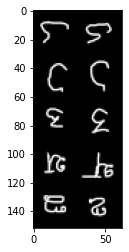

In [11]:
import matplotlib.pylab as plt
from torchvision import utils
X, y = tasksets.train.sample()
print("X.size:", X.size())
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [8]:
def get_indices(X, ways, shots):
    # Separate data into Meta-Train/Meta-Test sets
    meta_train_indices = np.zeros(X.size(0), dtype=bool)
    # print("X:", X.size())
    meta_train_indices[np.arange(shots * ways) * 2] = True
    meta_test_indices = torch.from_numpy(~meta_train_indices)
    meta_train_indices = torch.from_numpy(meta_train_indices)
    return meta_train_indices, meta_test_indices

def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

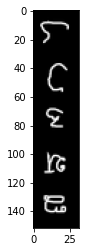

In [13]:
meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
#Adaptation Data
grid = utils.make_grid(X[meta_train_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

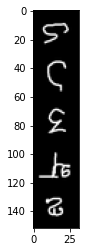

In [14]:
#Adaptation Data
grid = utils.make_grid(X[meta_test_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Validation: tensor([3, 3, 0, 0, 4, 4, 1, 1, 2, 2])


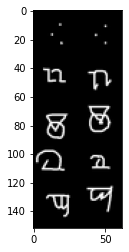

In [15]:
X, y = tasksets.validation.sample()
print("Validation:", y)
grid = utils.make_grid(X, nrow=shots*2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Test: tensor([1, 1, 0, 0, 4, 4, 2, 2, 3, 3])


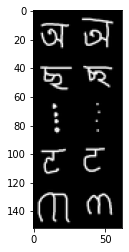

In [16]:
X, y = tasksets.test.sample()
print("Test:", y)
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [4]:
model = resnet.ResNet18S(out_dim=ways).to(device)
print(model)
# model = resnet18(pretrained=True).to(device)
# for param in model.parameters():
#     param.requires_grad = False
# num_ftrs = model.fc.in_features

# num_ftrs 
# model.fc = nn.Linear(num_ftrs, ways).to(device)

# print(model(torch.rand((1,3,84,84)).to(device)))
# torchsummary.summary(model, input_size= (3, 84, 84))

NameError: name 'ways' is not defined

In [18]:
# print(model.conv1.weight[0].grad)

In [19]:


# def main(argv):
    

In [9]:

meta_lr_lst = [0.01, 0.05, 0.09, 0.001, 0.005, 0.009]
fast_lr_lst = [0.1, 0.5, 0.9, 0.01, 0.05, 0.09, 0.001, 0.005, 0.009]
adaptation_steps_lst = [1, 5]
shots_lst = [1, 5]
meta_batch_lst = [8]



# meta_lr_lst = [0.01, 0.05, 0.09, 0.001, 0.005, 0.009]
# fast_lr_lst = [0.1, 0.5, 0.9, 0.01, 0.05, 0.09, 0.001, 0.005, 0.009]
# adaptation_steps_lst = [1, 5]
# shots_lst = [1, 5]
# meta_batch_lst = [4, 8, 16, 32]



epochs = 1000
ways = 5
dataset_name = "omniglot"
model = resnet.ResNet18S(out_dim=ways).to(device)

for meta_lr in meta_lr_lst:
    for fast_lr in fast_lr_lst:
        for adaptation_steps in adaptation_steps_lst:
            for shots in shots_lst:
                for meta_batch in meta_batch_lst:

        #             meta_lr = 0.005
        #             fast_lr = 0.01
        #             adaptation_steps = 1
                    optim_meta = optim.Adam(model.parameters(), lr=meta_lr)
                    epochs = 1000
                    # pp = ProgressPlot(plot_names=["ACC", "LOSS"],
                    #                   line_names=["SS", "QS"])
                    tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                              num_tasks=-1)



                    WANDB_LOGGER = True
                    if(WANDB_LOGGER):
                        import wandb
                        wandb.init(project="JOmniGlot", entity="hikmatkhan-", reinit=True)
                        wandb.watch(model, log_freq=10)
                        wandb.log({"Dataset":dataset_name,
                                  "Ways":ways,
                                  "Shots":shots,
                                  "Meta Batch": meta_batch,
                                  "Meta_lr": meta_lr,
                                  "Fast_lr": fast_lr,
                                  "Adaptation Step": adaptation_steps})
        #             if __name__ == "__main__":

                #     meta_train_spt_loss = mlogger.metric.Average()
                #     meta_train_spt_acc = mlogger.metric.Average()
                #     meta_train_qry_loss = mlogger.metric.Average()
                #     meta_train_qry_acc = mlogger.metric.Average()

                    for e in range(epochs):
                        optim_meta.zero_grad()
                        model.train()
                        meta_train_loss = mlogger.metric.Average()
                        meta_train_acc = mlogger.metric.Average()
                        meta_val_loss = mlogger.metric.Average()
                        meta_val_acc = mlogger.metric.Average()
                        meta_test_loss = mlogger.metric.Average()
                        meta_test_acc = mlogger.metric.Average()
                        for t in range(meta_batch):
                            X, y = tasksets.train.sample()

                            X, y = X.to(device), y.to(device)
                #             print(X.size())
                            meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast, copy_initial_weights=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_train_spt_loss = F.cross_entropy(y_prd, y[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_train_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X[meta_test_indices])
                                meta_train_acc.update(accuracy(y_prd, y[meta_test_indices]))
                                meta_train_qry_loss = F.cross_entropy(y_prd, y[meta_test_indices])
                                meta_train_loss.update(meta_train_qry_loss.detach().cpu().item())

                                meta_train_qry_loss.backward()


                        optim_meta.step()
                        if(WANDB_LOGGER):
                            wandb.log({"Meta Update": e})
                        print("Meta-Update")

                        for t in range(meta_batch):
                            model.eval()
                            X_val, y_val = tasksets.validation.sample()
                            X_val, y_val = X_val.to(device), y_val.to(device)

                #             print(X.size())
                            meta_train_indices, meta_test_indices = get_indices(X=X_val, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X_val[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_val_spt_loss = F.cross_entropy(y_prd, y_val[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_val_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X_val[meta_test_indices])
                                meta_val_acc.update(accuracy(y_prd, y_val[meta_test_indices]))
                                meta_val_qry_loss = F.cross_entropy(y_prd, y_val[meta_test_indices])
                                meta_val_loss.update(meta_val_qry_loss.detach().cpu().item())



                        for t in range(meta_batch):
                            model.eval()
                            X_test, y_test = tasksets.test.sample()
                            X_test, y_test = X_test.to(device), y_test.to(device)

                            meta_train_indices, meta_test_indices = get_indices(X=X_test, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X_test[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_test_spt_loss = F.cross_entropy(y_prd, y_test[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_test_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X_test[meta_test_indices])
                                meta_test_acc.update(accuracy(y_prd, y_test[meta_test_indices]))
                                meta_test_qry_loss = F.cross_entropy(y_prd, y_test[meta_test_indices])
                                meta_test_loss.update(meta_test_qry_loss.detach().cpu().item())


                #                 meta_train_qry_loss.backward()

                        if(WANDB_LOGGER):
                            wandb.log({
                                   "Meta Train Acc": meta_train_acc.value,
                                   "Meta Train Loss": meta_train_loss.value,
                                    "Meta Val Acc": meta_val_acc.value,
                                    "Meta Val Loss": meta_val_loss.value,
                                    "Meta Test Acc": meta_test_acc.value,
                                    "Meta Test Loss": meta_test_loss.value
                                   })
                        print("Epoch|", e, "|", "Meta Train Acc:", meta_train_acc.value, " Meta Train Loss:", meta_train_loss.value,
                             "Meta Val Acc:", meta_val_acc.value, " Meta Val Loss:", meta_val_loss.value,
                             "Meta Test Acc:", meta_test_acc.value, " Meta Test Loss:", meta_test_loss.value)


                        meta_train_loss.reset()
                        meta_train_acc.reset()
                        meta_val_loss.reset()
                        meta_val_acc.reset()
                        meta_test_loss.reset()
                        meta_test_acc.reset()

                
    

Files already downloaded and verified
Files already downloaded and verified


wandb: Currently logged in as: hikmatkhan- (use `wandb login --relogin` to force relogin)


Meta-Update
Epoch| 0 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 10.27737957239151 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.4018026026041763e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4995835790371792e+20
Meta-Update
Epoch| 1 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 9.936675727367403 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.2102075050096064e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.567282032207986e+18
Meta-Update
Epoch| 2 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 9.606988847255707 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.325330928076325e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.481718246466126e+18
Meta-Update
Epoch| 3 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 9.34119164943695 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.072845846742303e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.4662517413290967e+18
Meta-Update
Epoch| 4 | Meta Train

Meta-Update
Epoch| 34 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 7.4118101596832275 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.898194280593385e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.734745058203035e+19
Meta-Update
Epoch| 35 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 9.365360140800476 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.984482908605198e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.31061900310007e+19
Meta-Update
Epoch| 36 | Meta Train Acc: 0.2750000059604644  Meta Train Loss: 8.501483917236328 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.254914775355543e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.364553292001785e+19
Meta-Update
Epoch| 37 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 10.248597383499147 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.04029197673279e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.600449113694614e+19
Meta-Update
Epoch| 38 | Meta Trai

Meta-Update
Epoch| 68 | Meta Train Acc: 0.2750000040978193  Meta Train Loss: 7.298564523458481 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.5101634167573053e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.7799573880928993e+18
Meta-Update
Epoch| 69 | Meta Train Acc: 0.2250000033527613  Meta Train Loss: 8.37547767162323 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.5462979386912276e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.8600214711854694e+18
Meta-Update
Epoch| 70 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 8.531236410140991 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.0726139327149504e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.4092132341218017e+18
Meta-Update
Epoch| 71 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 8.684571206569672 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.1574805795184312e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0475505651597967e+18
Meta-Update
Epoch| 72 | Met

Meta-Update
Epoch| 102 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 9.487870216369629 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.671957831527956e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.974678293465005e+17
Meta-Update
Epoch| 103 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 10.528749823570251 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.40710334746067e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.167404315047363e+17
Meta-Update
Epoch| 104 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 8.048423260450363 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.924898291064504e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.535722628540006e+17
Meta-Update
Epoch| 105 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 8.474452644586563 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.691757201265787e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.006376870096404e+17
Meta-Update
Epoch| 106 | Meta

Meta-Update
Epoch| 136 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 8.82969880104065 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.841203598937293e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.6015185838106214e+17
Meta-Update
Epoch| 137 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 10.134200930595396 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.8470160211286426e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.4357703957623597e+17
Meta-Update
Epoch| 138 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 8.76397716999054 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.956196307482706e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.352887233575649e+17
Meta-Update
Epoch| 139 | Meta Train Acc: 0.2000000029802322  Meta Train Loss: 9.358801960945128 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.547941197638534e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.942597437487841e+17
Meta-Update
Epoch| 140 | Meta

Meta-Update
Epoch| 170 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 7.408103913068772 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.167219194523812e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.1103969489964234e+18
Meta-Update
Epoch| 171 | Meta Train Acc: 0.2750000059604645  Meta Train Loss: 9.165821194648743 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.3483015268935926e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.2424830503676805e+18
Meta-Update
Epoch| 172 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 8.516538739204405 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.6555637449474703e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.8959919425485537e+18
Meta-Update
Epoch| 173 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 10.13710629940033 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.65672781852364e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.089566530896134e+18
Meta-Update
Epoch| 174 | M

Meta-Update
Epoch| 204 | Meta Train Acc: 0.10000000149011612  Meta Train Loss: 6.819111853837967 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.6075195692728978e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4593826940801516e+18
Meta-Update
Epoch| 205 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 9.008942246437073 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2867752942580529e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.5218823881566454e+18
Meta-Update
Epoch| 206 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 6.570107817649841 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0181537630949212e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4663237048278715e+18
Meta-Update
Epoch| 207 | Meta Train Acc: 0.12500000186264515  Meta Train Loss: 5.767782896757126 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0995310324382432e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.13834968889688e+17
Meta-Update
Epoch| 208 

Meta-Update
Epoch| 238 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 6.630433082580565 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.329743382716088e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.0427648134375014e+17
Meta-Update
Epoch| 239 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 6.5210321843624115 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.940193939925238e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.170845419718574e+17
Meta-Update
Epoch| 240 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 8.029516637325287 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.754192940141117e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.123005346671493e+17
Meta-Update
Epoch| 241 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 6.833611801266669 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.709377211265188e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.0930034968703795e+17
Meta-Update
Epoch| 242 | M

Meta-Update
Epoch| 272 | Meta Train Acc: 0.22500000335276124  Meta Train Loss: 7.074647948145867 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.273167411026329e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.452274741752628e+16
Meta-Update
Epoch| 273 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 6.3680528700351715 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.2835377702109184e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.6018106308493316e+16
Meta-Update
Epoch| 274 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 5.982746839523315 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.6109510452051968e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.191695759487795e+16
Meta-Update
Epoch| 275 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 5.556907802820205 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.6075946222157824e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.967304803876864e+16
Meta-Update
Epoch| 276 | M

Meta-Update
Epoch| 306 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 4.685900345444679 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.59499787443241e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.378809299723878e+16
Meta-Update
Epoch| 307 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 5.313468933105468 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.20822707725271e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.177827728228352e+16
Meta-Update
Epoch| 308 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 5.0091517716646194 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.666043398907494e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.14676502233088e+16
Meta-Update
Epoch| 309 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 7.744519680738448 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.430386677383168e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.853712827469003e+16
Meta-Update
Epoch| 310 | Meta T

Meta-Update
Epoch| 340 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 6.91191965341568 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.832772572353659e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.4845149401907206e+17
Meta-Update
Epoch| 341 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 5.525401413440704 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.614830647452631e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.020375632933028e+17
Meta-Update
Epoch| 342 | Meta Train Acc: 0.2250000033527613  Meta Train Loss: 4.584489494562149 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.54975504822698e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.79448069561516e+17
Meta-Update
Epoch| 343 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 7.275125116109849 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.6501018910366106e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.6740023532467e+17
Meta-Update
Epoch| 344 | Meta Tra

Meta-Update
Epoch| 374 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 5.995417088270187 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1888938313958031e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2399349994031677e+18
Meta-Update
Epoch| 375 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 5.348654851317405 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3883968575913329e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4149704730867139e+18
Meta-Update
Epoch| 376 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 4.240854740142822 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.5350932952422812e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.432181807201124e+18
Meta-Update
Epoch| 377 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 5.881066024303436 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.6300127940383867e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.5878880983966026e+18
Meta-Update
Epoch| 378 

Meta-Update
Epoch| 408 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 3.771059736609459 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2710317823969193e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.290978830290256e+18
Meta-Update
Epoch| 409 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.5417756289243694 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3031703956076628e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2693529827601285e+18
Meta-Update
Epoch| 410 | Meta Train Acc: 0.3000000063329935  Meta Train Loss: 4.654645219445229 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2144811076516577e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3737266666474045e+18
Meta-Update
Epoch| 411 | Meta Train Acc: 0.17500000447034836  Meta Train Loss: 5.1303104162216195 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.397595998934532e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4312748647270318e+18
Meta-Update
Epoch| 412

Meta-Update
Epoch| 442 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 6.024789571762085 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.445091980676694e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3810844867913318e+18
Meta-Update
Epoch| 443 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 5.146833941340447 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3080042352704225e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.5692066055667054e+18
Meta-Update
Epoch| 444 | Meta Train Acc: 0.22500000521540642  Meta Train Loss: 4.708559602499008 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2014784807100744e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3517480133237146e+18
Meta-Update
Epoch| 445 | Meta Train Acc: 0.22500000335276124  Meta Train Loss: 4.641913577914238 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3640226948482335e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.6662440901754225e+18
Meta-Update
Epoch| 446

Meta-Update
Epoch| 476 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.9624924659729004 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.1985519945604137e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.1389758503625687e+18
Meta-Update
Epoch| 477 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 4.403023108839989 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.1048501189927242e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.144660205219086e+18
Meta-Update
Epoch| 478 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.9210742413997655 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.0220141327267922e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0394757174056714e+18
Meta-Update
Epoch| 479 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.7058019340038304 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.995996698316374e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0419935474936712e+18
Meta-Update
Epoch| 4

Meta-Update
Epoch| 510 | Meta Train Acc: 0.12500000186264515  Meta Train Loss: 6.533406242728233 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.7833036486528205e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.220442306188411e+17
Meta-Update
Epoch| 511 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 3.9571402668952937 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.2414990862450688e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.4899589929487568e+17
Meta-Update
Epoch| 512 | Meta Train Acc: 0.17500000260770318  Meta Train Loss: 6.140531480312348 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.5872250036813816e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.35064459575296e+16
Meta-Update
Epoch| 513 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 4.45530441403389 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.1622557754497434e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.146711048633713e+17
Meta-Update
Epoch| 514 | 

Meta-Update
Epoch| 544 | Meta Train Acc: 0.10000000149011613  Meta Train Loss: 4.6215900182724 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.756226701809943e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.631622675473105e+18
Meta-Update
Epoch| 545 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 3.5041148364543924 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.947113708755354e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.327202299840037e+18
Meta-Update
Epoch| 546 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 5.094051584601402 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.0717106383196e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.732449200383458e+18
Meta-Update
Epoch| 547 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 4.779182285070419 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.269966759686308e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.447286664858436e+18
Meta-Update
Epoch| 548 | Meta T

Meta-Update
Epoch| 578 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 5.737336486577987 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.0754164469792244e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0397863878520734e+19
Meta-Update
Epoch| 579 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 4.410692095756531 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.100179070616391e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0902392655989703e+19
Meta-Update
Epoch| 580 | Meta Train Acc: 0.3000000044703483  Meta Train Loss: 5.018504440784454 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.0558207171027796e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0897484985839124e+19
Meta-Update
Epoch| 581 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 6.723088651895523 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.578873599184077e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.2432565396179513e+19
Meta-Update
Epoch| 582 

Meta-Update
Epoch| 612 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 4.3410412073135385 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.213029682889412e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.637160136038888e+19
Meta-Update
Epoch| 613 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 4.968138754367828 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.9353257660293054e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.035724791099645e+20
Meta-Update
Epoch| 614 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 5.315931499004364 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.4813293727924625e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.559171000774531e+19
Meta-Update
Epoch| 615 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 5.646765351295471 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.0353588803758195e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.483157348108206e+20
Meta-Update
Epoch| 616 | M

Meta-Update
Epoch| 646 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 4.702388361096382 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.189161228727246e+23 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.63767912880708e+23
Meta-Update
Epoch| 647 | Meta Train Acc: 0.30000000447034836  Meta Train Loss: 4.5185764133930215 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.6986603000431036e+23 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.963772483335623e+23
Meta-Update
Epoch| 648 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 3.9868153035640717 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.7857779540905856e+23 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.96986592118545e+23
Meta-Update
Epoch| 649 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 5.1888030022382745 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.410608649580232e+23 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.728787062534034e+23
Meta-Update
Epoch| 650 | M

Meta-Update
Epoch| 680 | Meta Train Acc: 0.27500000409781933  Meta Train Loss: 4.168452128767967 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.4927656995400122e+24 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.6624258361270696e+24
Meta-Update
Epoch| 681 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 2.7835054844617844 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.5361549830950958e+22 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.4615773917790524e+22
Meta-Update
Epoch| 682 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 5.262443333864212 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.953328790539914e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.208936926426369e+20
Meta-Update
Epoch| 683 | Meta Train Acc: 0.2000000029802322  Meta Train Loss: 6.389933973550796 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.875761158906131e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.8067879615172755e+20
Meta-Update
Epoch| 684 | 

Meta-Update
Epoch| 714 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 4.558327436447143 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.428903002366762e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.151554402884864e+20
Meta-Update
Epoch| 715 | Meta Train Acc: 0.22500000521540642  Meta Train Loss: 5.765574932098389 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.2145573737821897e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.9897344387739078e+20
Meta-Update
Epoch| 716 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 5.0704129338264465 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.071869676155117e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.8716425963578592e+20
Meta-Update
Epoch| 717 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 6.614245921373367 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.8525181831357766e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4698417510229318e+20
Meta-Update
Epoch| 718 |

Meta-Update
Epoch| 748 | Meta Train Acc: 0.12500000186264515  Meta Train Loss: 4.893364042043686 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.181081840100049e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.2372335695398177e+18
Meta-Update
Epoch| 749 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 5.064918220043182 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.461036671779209e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.644101473666859e+18
Meta-Update
Epoch| 750 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 7.303538501262665 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.3941490572378767e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.2613578010326467e+18
Meta-Update
Epoch| 751 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 4.064434587955475 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.9382093579443236e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.3102431546420756e+18
Meta-Update
Epoch| 752 

Meta-Update
Epoch| 782 | Meta Train Acc: 0.2750000059604645  Meta Train Loss: 4.609512224793434 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.659115707514225e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.293073453297171e+17
Meta-Update
Epoch| 783 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 4.739816337823867 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.69601613956776e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.644286452456489e+17
Meta-Update
Epoch| 784 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 4.205595910549164 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.531568563427738e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.690190922503946e+17
Meta-Update
Epoch| 785 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 5.475267440080643 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.946517540038246e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.124293135623784e+17
Meta-Update
Epoch| 786 | Meta T

Meta-Update
Epoch| 816 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.705557331442833 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.5234789652693e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0180196913958093e+18
Meta-Update
Epoch| 817 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 4.666630417108537 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1512220934220023e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.286871176924366e+17
Meta-Update
Epoch| 818 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 4.690469413995743 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.042837261275629e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.789520191750144e+17
Meta-Update
Epoch| 819 | Meta Train Acc: 0.3250000067055225  Meta Train Loss: 4.069026291370392 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.633449783303864e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.163685577413886e+18
Meta-Update
Epoch| 820 | Meta

Meta-Update
Epoch| 850 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 3.546588495373726 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.251568828282485e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0513040222919223e+20
Meta-Update
Epoch| 851 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 5.854110926389694 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.2102692144125208e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.3923018856059526e+20
Meta-Update
Epoch| 852 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 5.105882316827775 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.1532720709448922e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.7680013034628265e+20
Meta-Update
Epoch| 853 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 7.748443156480789 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.703483434490512e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.5417828333618672e+20
Meta-Update
Epoch| 854

Meta-Update
Epoch| 884 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 4.831299215555191 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0436412803171903e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1285296472856828e+20
Meta-Update
Epoch| 885 | Meta Train Acc: 0.2000000029802322  Meta Train Loss: 3.479424849152565 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0142749135335955e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0309929328583482e+20
Meta-Update
Epoch| 886 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 5.836887538433075 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.652803129509308e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0645184992421452e+20
Meta-Update
Epoch| 887 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 4.586481779813767 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0331950842244812e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.725572323574022e+19
Meta-Update
Epoch| 888 | 

Meta-Update
Epoch| 918 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 5.490269094705582 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.722401280962645e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.704080609590536e+19
Meta-Update
Epoch| 919 | Meta Train Acc: 0.22500000335276127  Meta Train Loss: 3.853324294090272 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.976806171446293e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.556502784520906e+19
Meta-Update
Epoch| 920 | Meta Train Acc: 0.22500000521540645  Meta Train Loss: 2.7924154847860336 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.606939803761928e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.838293268042508e+19
Meta-Update
Epoch| 921 | Meta Train Acc: 0.1750000026077032  Meta Train Loss: 5.403026342391969 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.613320656516337e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0113840610691724e+20
Meta-Update
Epoch| 922 | Me

Meta-Update
Epoch| 952 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.447262182831764 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.011228972654211e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.920645100519136e+19
Meta-Update
Epoch| 953 | Meta Train Acc: 0.2250000033527613  Meta Train Loss: 3.5491247326135635 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.186248187078195e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.594013511109208e+19
Meta-Update
Epoch| 954 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 3.1068765819072723 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.045630162610579e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.99391006632617e+19
Meta-Update
Epoch| 955 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 3.872858628630638 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.170694634979984e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.691805035406924e+19
Meta-Update
Epoch| 956 | Meta 

Meta-Update
Epoch| 986 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.911474257707596 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.721633437017388e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.683184946708532e+19
Meta-Update
Epoch| 987 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 2.9496566951274876 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.618613648567514e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.178155610722953e+19
Meta-Update
Epoch| 988 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 3.4443219155073166 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.933572274730513e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1477723817028094e+20
Meta-Update
Epoch| 989 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.4380781054496765 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.870356240469958e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.832463272562971e+19
Meta-Update
Epoch| 990 |

Dataset,omniglot
Ways,5
Shots,1
Meta Batch,8
Meta_lr,0.01
Fast_lr,0.1
Adaptation Step,1
_runtime,7449
_timestamp,1629344067
_step,2000
Meta Update,999


Ways,▁
Shots,▁
Meta Batch,▁
Meta_lr,▁
Fast_lr,▁
Adaptation Step,▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Update,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Train Acc,▇▅▆▆▂▇▆▅▁▅▆▅█▅▇▅▅▅▅▅▃▅▂█▅▅▆▃▆▃▆▃▆▇▁▇▆▇▅▅


Meta-Update
Epoch| 0 | Meta Train Acc: 0.21499999053776264  Meta Train Loss: 3.2685746848583217 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.8911432412681575e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.5045280588877008e+20
Meta-Update
Epoch| 1 | Meta Train Acc: 0.12999999430030584  Meta Train Loss: 4.870569944381714 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.1962453614146565e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.810242050907655e+21
Meta-Update
Epoch| 2 | Meta Train Acc: 0.23999999091029167  Meta Train Loss: 4.1256053596735 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.728385016006045e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.143658635212283e+21
Meta-Update
Epoch| 3 | Meta Train Acc: 0.20999999064952132  Meta Train Loss: 3.83082653582096 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.015816430333747e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.180257951722051e+21
Meta-Update
Epoch| 4 | Meta Train A

Meta-Update
Epoch| 34 | Meta Train Acc: 0.2549999887123704  Meta Train Loss: 2.17205885052681 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.1627608121219974e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.190396406396414e+22
Meta-Update
Epoch| 35 | Meta Train Acc: 0.24999999161809686  Meta Train Loss: 2.194257989525795 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.60121417606559e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.2447437345674496e+22
Meta-Update
Epoch| 36 | Meta Train Acc: 0.1949999947100878  Meta Train Loss: 2.6982847005128856 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.382583576635538e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.9796617095168225e+22
Meta-Update
Epoch| 37 | Meta Train Acc: 0.2099999925121665  Meta Train Loss: 2.3279358744621277 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.36315697380716e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.35668902257945e+22
Meta-Update
Epoch| 38 | Meta Train

Meta-Update
Epoch| 68 | Meta Train Acc: 0.24499999545514584  Meta Train Loss: 1.8286740630865097 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.906892786666757e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3896517035583028e+24
Meta-Update
Epoch| 69 | Meta Train Acc: 0.2999999895691872  Meta Train Loss: 1.5241952687501907 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5778233572407098e+24 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.5128615897396708e+24
Meta-Update
Epoch| 70 | Meta Train Acc: 0.2749999910593033  Meta Train Loss: 1.6923023611307142 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.6556140853956763e+24 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1228815133075671e+24
Meta-Update
Epoch| 71 | Meta Train Acc: 0.24999999254941938  Meta Train Loss: 1.8949967771768572 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3708967849174914e+24 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0743092500740541e+24
Meta-Update
Epoch| 72 |

Meta-Update
Epoch| 102 | Meta Train Acc: 0.26499999314546585  Meta Train Loss: 2.0500328689813614 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.28315398789388e+24 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.165205308128197e+24
Meta-Update
Epoch| 103 | Meta Train Acc: 0.23999999277293682  Meta Train Loss: 2.5837780237197876 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1086828328169313e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.8752309453345359e+25
Meta-Update
Epoch| 104 | Meta Train Acc: 0.2299999939277768  Meta Train Loss: 2.2116415798664097 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2641336388009535e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2094989693204866e+25
Meta-Update
Epoch| 105 | Meta Train Acc: 0.1999999936670065  Meta Train Loss: 2.332496389746666 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2049914317456019e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.015955490907626e+25
Meta-Update
Epoch| 106 

Meta-Update
Epoch| 136 | Meta Train Acc: 0.2649999912828207  Meta Train Loss: 1.7730863094329836 Meta Val Acc: 0.19499998912215233  Meta Val Loss: 1.0061647864645523e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.986678884513853e+22
Meta-Update
Epoch| 137 | Meta Train Acc: 0.27499998919665813  Meta Train Loss: 1.6234479546546934 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.6021357966346898e+23 Meta Test Acc: 0.19499998912215233  Meta Test Loss: 9.690290328046783e+22
Meta-Update
Epoch| 138 | Meta Train Acc: 0.23499999288469547  Meta Train Loss: 1.7106274664402008 Meta Val Acc: 0.2149999886751175  Meta Val Loss: 2.4087273486360055e+23 Meta Test Acc: 0.2199999913573265  Meta Test Loss: 1.2913460004885528e+23
Meta-Update
Epoch| 139 | Meta Train Acc: 0.29499999061226845  Meta Train Loss: 1.6285080015659332 Meta Val Acc: 0.20499999076128006  Meta Val Loss: 9.46642686143933e+22 Meta Test Acc: 0.20499999076128006  Meta Test Loss: 1.0859409929433392e+23
Meta-Update
Epoch| 140 

Meta-Update
Epoch| 170 | Meta Train Acc: 0.294999991543591  Meta Train Loss: 1.5799124389886856 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3724558522954936e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.6662107715921026e+23
Meta-Update
Epoch| 171 | Meta Train Acc: 0.24999998975545162  Meta Train Loss: 1.6168215721845627 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.07095977475002e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.106242240868236e+23
Meta-Update
Epoch| 172 | Meta Train Acc: 0.20999999158084393  Meta Train Loss: 1.6663229316473007 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.8559616665270428e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.9390776805649933e+23
Meta-Update
Epoch| 173 | Meta Train Acc: 0.25499998684972525  Meta Train Loss: 1.703919380903244 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.4087512230059012e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.6558916853625366e+23
Meta-Update
Epoch| 174

Meta-Update
Epoch| 204 | Meta Train Acc: 0.30999999213963747  Meta Train Loss: 1.783098727464676 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.2394414581379126e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.8969083158637312e+23
Meta-Update
Epoch| 205 | Meta Train Acc: 0.2199999941512943  Meta Train Loss: 1.9946060180664058 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.650412008991298e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.7106634053470752e+23
Meta-Update
Epoch| 206 | Meta Train Acc: 0.18999999295920134  Meta Train Loss: 2.035735562443733 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.864135938653102e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.55866547947247e+22
Meta-Update
Epoch| 207 | Meta Train Acc: 0.23499999288469553  Meta Train Loss: 1.9885847419500349 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.092731606929756e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.43063877585332e+22
Meta-Update
Epoch| 208 | M

Meta-Update
Epoch| 238 | Meta Train Acc: 0.2049999926239252  Meta Train Loss: 1.7393277138471601 Meta Val Acc: 0.1999999899417162  Meta Val Loss: 1.5386834457331358e+22 Meta Test Acc: 0.19499998912215233  Meta Test Loss: 1.935496769985029e+22
Meta-Update
Epoch| 239 | Meta Train Acc: 0.239999994635582  Meta Train Loss: 1.702016189694405 Meta Val Acc: 0.17499999050050974  Meta Val Loss: 2.142987336815308e+22 Meta Test Acc: 0.2149999886751175  Meta Test Loss: 1.5260659428739877e+22
Meta-Update
Epoch| 240 | Meta Train Acc: 0.1599999964237213  Meta Train Loss: 1.6710811406373978 Meta Val Acc: 0.18999999016523358  Meta Val Loss: 1.5790508030453132e+22 Meta Test Acc: 0.2049999888986349  Meta Test Loss: 1.149741449578091e+22
Meta-Update
Epoch| 241 | Meta Train Acc: 0.23999999463558197  Meta Train Loss: 1.6150276064872744 Meta Val Acc: 0.19499998912215233  Meta Val Loss: 1.0171772099349428e+22 Meta Test Acc: 0.22499999031424525  Meta Test Loss: 8.759149290777239e+21
Meta-Update
Epoch| 242 | Met

Meta-Update
Epoch| 272 | Meta Train Acc: 0.22499999403953552  Meta Train Loss: 1.6190295815467834 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3747680569910244e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3148910198913667e+21
Meta-Update
Epoch| 273 | Meta Train Acc: 0.19499999284744265  Meta Train Loss: 1.8085434883832932 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.3038633253337437e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.6122499077142468e+21
Meta-Update
Epoch| 274 | Meta Train Acc: 0.20999999437481165  Meta Train Loss: 1.7861988395452502 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3592727077904984e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.187108573018453e+20
Meta-Update
Epoch| 275 | Meta Train Acc: 0.2299999929964542  Meta Train Loss: 1.794177755713463 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.369279046705207e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.138795204262558e+20
Meta-Update
Epoch| 27

Meta-Update
Epoch| 306 | Meta Train Acc: 0.26499999314546585  Meta Train Loss: 1.5847190916538239 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.578227256521579e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2796217830970564e+22
Meta-Update
Epoch| 307 | Meta Train Acc: 0.22499999310821295  Meta Train Loss: 1.581233099102974 Meta Val Acc: 0.17999998945742846  Meta Val Loss: 1.7431823364220403e+22 Meta Test Acc: 0.2049999888986349  Meta Test Loss: 1.4719285693367716e+22
Meta-Update
Epoch| 308 | Meta Train Acc: 0.3199999909847975  Meta Train Loss: 1.6275384128093722 Meta Val Acc: 0.18999998923391104  Meta Val Loss: 9.235024326834412e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.810199643493176e+21
Meta-Update
Epoch| 309 | Meta Train Acc: 0.239999994635582  Meta Train Loss: 1.632385641336441 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1733318216365273e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.1997399607601e+21
Meta-Update
Epoch| 310 | Met

Meta-Update
Epoch| 340 | Meta Train Acc: 0.2999999895691871  Meta Train Loss: 1.4914307445287704 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.509620063411016e+20 Meta Test Acc: 0.22499998658895495  Meta Test Loss: 1.0842652277992115e+21
Meta-Update
Epoch| 341 | Meta Train Acc: 0.28999998513609165  Meta Train Loss: 1.4798973500728607 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.955593508366886e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.7302283252597785e+20
Meta-Update
Epoch| 342 | Meta Train Acc: 0.3199999928474427  Meta Train Loss: 1.4996493756771088 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.585811581226178e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.392198776603195e+20
Meta-Update
Epoch| 343 | Meta Train Acc: 0.26999998930841684  Meta Train Loss: 1.5390509068965912 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.648043631495044e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.376933335034369e+20
Meta-Update
Epoch| 344 |

Meta-Update
Epoch| 374 | Meta Train Acc: 0.31499999202787876  Meta Train Loss: 1.4467149823904037 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3125532074820638e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.6726215964035438e+21
Meta-Update
Epoch| 375 | Meta Train Acc: 0.3349999897181988  Meta Train Loss: 1.4569116085767748 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3129576562372714e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.8028598306330522e+21
Meta-Update
Epoch| 376 | Meta Train Acc: 0.19499999471008775  Meta Train Loss: 1.6770070642232895 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3661759277738156e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.597425033007757e+21
Meta-Update
Epoch| 377 | Meta Train Acc: 0.3399999886751175  Meta Train Loss: 1.5001791268587112 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2693843622722294e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.6375331569539036e+21
Meta-Update
Epoch| 

Meta-Update
Epoch| 408 | Meta Train Acc: 0.21499999426305297  Meta Train Loss: 1.639938473701477 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.066348167853785e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.883252907382041e+21
Meta-Update
Epoch| 409 | Meta Train Acc: 0.23999999370425942  Meta Train Loss: 1.7354278415441513 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.530809993189686e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.814161247909395e+21
Meta-Update
Epoch| 410 | Meta Train Acc: 0.2849999880418182  Meta Train Loss: 1.4773944318294523 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.563379833179455e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.2434859073390227e+21
Meta-Update
Epoch| 411 | Meta Train Acc: 0.18999999482184646  Meta Train Loss: 1.6879673153162003 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.68356468868846e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.7089841509261236e+21
Meta-Update
Epoch| 412 | 

Meta-Update
Epoch| 442 | Meta Train Acc: 0.29999998956918716  Meta Train Loss: 1.4792188405990603 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.697393321387926e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.3019637868652287e+22
Meta-Update
Epoch| 443 | Meta Train Acc: 0.2749999919906259  Meta Train Loss: 1.5256325006484988 Meta Val Acc: 0.20499998889863494  Meta Val Loss: 2.3395248819505933e+22 Meta Test Acc: 0.179999990388751  Meta Test Loss: 1.7134803351378764e+22
Meta-Update
Epoch| 444 | Meta Train Acc: 0.26999999489635235  Meta Train Loss: 1.5331892222166061 Meta Val Acc: 0.19999999087303877  Meta Val Loss: 1.5795973605997781e+22 Meta Test Acc: 0.18999999016523358  Meta Test Loss: 1.8313561795941603e+22
Meta-Update
Epoch| 445 | Meta Train Acc: 0.2949999924749136  Meta Train Loss: 1.526107981801033 Meta Val Acc: 0.19499999284744263  Meta Val Loss: 1.6252311041709005e+22 Meta Test Acc: 0.1999999899417162  Meta Test Loss: 2.4453624005335578e+22
Meta-Update
Epoch| 446 

Meta-Update
Epoch| 476 | Meta Train Acc: 0.35999999288469553  Meta Train Loss: 1.4914683401584625 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.967146851405314e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.214016100350003e+22
Meta-Update
Epoch| 477 | Meta Train Acc: 0.4049999862909317  Meta Train Loss: 1.416444331407547 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.003828782960237e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.957161993179707e+22
Meta-Update
Epoch| 478 | Meta Train Acc: 0.309999986551702  Meta Train Loss: 1.5617739409208298 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.526246828488788e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0752610301232533e+23
Meta-Update
Epoch| 479 | Meta Train Acc: 0.35999999009072775  Meta Train Loss: 1.412882328033447 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.974501195482183e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.138708157805268e+22
Meta-Update
Epoch| 480 | Met

Meta-Update
Epoch| 510 | Meta Train Acc: 0.3349999897181988  Meta Train Loss: 1.4350921511650085 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.4700622656885026e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.714615201430102e+23
Meta-Update
Epoch| 511 | Meta Train Acc: 0.3299999944865703  Meta Train Loss: 1.5156022459268568 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.871056021110131e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.2342243585134477e+23
Meta-Update
Epoch| 512 | Meta Train Acc: 0.3049999913200736  Meta Train Loss: 1.499914437532425 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.734837348919414e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.175172203184445e+23
Meta-Update
Epoch| 513 | Meta Train Acc: 0.3499999847263098  Meta Train Loss: 1.4122556149959564 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.8409563255905906e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.6993512806915446e+23
Meta-Update
Epoch| 514 | 

Meta-Update
Epoch| 544 | Meta Train Acc: 0.32499999087303877  Meta Train Loss: 1.4481866508722308 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.7010473535373395e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.8863237083215056e+23
Meta-Update
Epoch| 545 | Meta Train Acc: 0.28499999176710844  Meta Train Loss: 1.4969515800476074 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.239664549574953e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.059866238269532e+23
Meta-Update
Epoch| 546 | Meta Train Acc: 0.29999999143183226  Meta Train Loss: 1.4144497066736221 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.1140810656421483e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.91894460898444e+23
Meta-Update
Epoch| 547 | Meta Train Acc: 0.29999998956918716  Meta Train Loss: 1.4884810000658033 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.0449531873484436e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.1367727904722556e+23
Meta-Update
Epoch| 5

Meta-Update
Epoch| 578 | Meta Train Acc: 0.3599999863654375  Meta Train Loss: 1.410966694355011 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.1245133727039753e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.605461170157047e+23
Meta-Update
Epoch| 579 | Meta Train Acc: 0.30999998934566975  Meta Train Loss: 1.4561125040054321 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.091827057594082e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.8219766142779786e+23
Meta-Update
Epoch| 580 | Meta Train Acc: 0.35499998554587364  Meta Train Loss: 1.4011122435331345 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.8770389413003596e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.3772366600765568e+23
Meta-Update
Epoch| 581 | Meta Train Acc: 0.35999998822808266  Meta Train Loss: 1.4895484000444414 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.17963066548455e+23 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.5505606528526653e+23
Meta-Update
Epoch| 582

Meta-Update
Epoch| 612 | Meta Train Acc: 0.3499999884516001  Meta Train Loss: 1.410613939166069 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.4516627508640854e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.586637529399967e+24
Meta-Update
Epoch| 613 | Meta Train Acc: 0.3099999893456698  Meta Train Loss: 1.455202728509903 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.357490359658904e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2035197778852869e+25
Meta-Update
Epoch| 614 | Meta Train Acc: 0.33999999146908527  Meta Train Loss: 1.484256610274315 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.443914266272078e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.0083841215172327e+25
Meta-Update
Epoch| 615 | Meta Train Acc: 0.3799999915063381  Meta Train Loss: 1.4065120667219162 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.878188120539138e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.9318965725144809e+25
Meta-Update
Epoch| 616 | M

Meta-Update
Epoch| 646 | Meta Train Acc: 0.40999998524785036  Meta Train Loss: 1.3543440848588941 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.691667713460982e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.912125918655817e+25
Meta-Update
Epoch| 647 | Meta Train Acc: 0.3199999891221524  Meta Train Loss: 1.3470130413770676 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.3228044422606556e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.9109677375099364e+25
Meta-Update
Epoch| 648 | Meta Train Acc: 0.39499998465180397  Meta Train Loss: 1.4343475550413132 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.61096434721158e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.624801552020073e+25
Meta-Update
Epoch| 649 | Meta Train Acc: 0.41499998793005943  Meta Train Loss: 1.2877597957849503 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.899940100964447e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.278757537345752e+25
Meta-Update
Epoch| 650 |

Meta-Update
Epoch| 680 | Meta Train Acc: 0.3249999899417162  Meta Train Loss: 1.4001594334840775 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.1967280680595042e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.1366048833304393e+25
Meta-Update
Epoch| 681 | Meta Train Acc: 0.3549999874085188  Meta Train Loss: 1.3830821514129639 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.432594767084606e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.1941896519597737e+25
Meta-Update
Epoch| 682 | Meta Train Acc: 0.32999998331069946  Meta Train Loss: 1.5249229073524475 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.8524900766622036e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.217152591328292e+25
Meta-Update
Epoch| 683 | Meta Train Acc: 0.404999990016222  Meta Train Loss: 1.339551031589508 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.2709390312376616e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.6227338610484277e+25
Meta-Update
Epoch| 684 

Meta-Update
Epoch| 714 | Meta Train Acc: 0.37999999430030584  Meta Train Loss: 1.4334319233894348 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.229269824038566e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.179791822968875e+25
Meta-Update
Epoch| 715 | Meta Train Acc: 0.32999998982995743  Meta Train Loss: 1.4069756120443342 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.412378402667294e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.712036075604067e+25
Meta-Update
Epoch| 716 | Meta Train Acc: 0.37499998323619366  Meta Train Loss: 1.3586054891347885 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.359133691749901e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.120071526659594e+25
Meta-Update
Epoch| 717 | Meta Train Acc: 0.379999989643693  Meta Train Loss: 1.3317401260137558 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.130796261902785e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.6042915119248635e+25
Meta-Update
Epoch| 718 | 

Meta-Update
Epoch| 748 | Meta Train Acc: 0.429999977350235  Meta Train Loss: 1.1672344505786896 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1125081543116226e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0123846029760424e+25
Meta-Update
Epoch| 749 | Meta Train Acc: 0.4599999897181988  Meta Train Loss: 1.2254806011915207 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1525909692172358e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0136415540291618e+25
Meta-Update
Epoch| 750 | Meta Train Acc: 0.3599999900907278  Meta Train Loss: 1.2929084450006485 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1318145743052422e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0078623548433348e+25
Meta-Update
Epoch| 751 | Meta Train Acc: 0.42499998584389687  Meta Train Loss: 1.2826736569404602 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0883840788727775e+25 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0740861876852303e+25
Meta-Update
Epoch| 7

Meta-Update
Epoch| 782 | Meta Train Acc: 0.3949999865144492  Meta Train Loss: 1.3229804933071139 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.583370803575776e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.312472296402819e+26
Meta-Update
Epoch| 783 | Meta Train Acc: 0.42499998956918716  Meta Train Loss: 1.3772313147783275 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.14520679271012e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.026734746389149e+26
Meta-Update
Epoch| 784 | Meta Train Acc: 0.35999998915940523  Meta Train Loss: 1.4715146571397781 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.17966232909121e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0448805478806086e+27
Meta-Update
Epoch| 785 | Meta Train Acc: 0.4099999852478504  Meta Train Loss: 1.4652288407087326 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5386663874465757e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.4610009555401234e+27
Meta-Update
Epoch| 786 | 

Meta-Update
Epoch| 816 | Meta Train Acc: 0.38999998942017555  Meta Train Loss: 1.2548059076070786 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.3880579708344165e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.5602220604636465e+27
Meta-Update
Epoch| 817 | Meta Train Acc: 0.4049999881535769  Meta Train Loss: 1.2776368856430054 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.5527912876756426e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.3872517374379312e+27
Meta-Update
Epoch| 818 | Meta Train Acc: 0.3999999910593033  Meta Train Loss: 1.3021811991930008 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.4117911459312818e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.4164224592854036e+27
Meta-Update
Epoch| 819 | Meta Train Acc: 0.45999999344348913  Meta Train Loss: 1.1704327389597893 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.7202161689446634e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.0942194893363918e+27
Meta-Update
Epoch|

Meta-Update
Epoch| 850 | Meta Train Acc: 0.419999985024333  Meta Train Loss: 1.3950802236795425 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.9418958506358732e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.900458818742635e+27
Meta-Update
Epoch| 851 | Meta Train Acc: 0.46499998494982714  Meta Train Loss: 1.1873883828520775 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.9065529589018017e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.9885120641822218e+27
Meta-Update
Epoch| 852 | Meta Train Acc: 0.5099999830126762  Meta Train Loss: 1.1032044291496277 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.202904514131964e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.0407712843146716e+27
Meta-Update
Epoch| 853 | Meta Train Acc: 0.4599999822676181  Meta Train Loss: 1.197522111237049 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.323075902187121e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.0585300570681522e+27
Meta-Update
Epoch| 854 |

Meta-Update
Epoch| 884 | Meta Train Acc: 0.5099999830126762  Meta Train Loss: 1.1708639711141586 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.523568479153805e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.009711094780271e+27
Meta-Update
Epoch| 885 | Meta Train Acc: 0.41999999433755875  Meta Train Loss: 1.2486270293593404 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.643051471613619e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.514799265956045e+27
Meta-Update
Epoch| 886 | Meta Train Acc: 0.4999999888241291  Meta Train Loss: 1.1976391002535818 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.3663263666341683e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.3027626681387003e+27
Meta-Update
Epoch| 887 | Meta Train Acc: 0.4399999901652336  Meta Train Loss: 1.1978148967027664 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.274215520027895e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.11952086597135e+27
Meta-Update
Epoch| 888 | M

Meta-Update
Epoch| 918 | Meta Train Acc: 0.4849999807775021  Meta Train Loss: 1.1224194467067719 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.977801877749087e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.614749596103922e+26
Meta-Update
Epoch| 919 | Meta Train Acc: 0.5199999883770943  Meta Train Loss: 1.082539327442646 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 9.066213617213e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.491886532940507e+26
Meta-Update
Epoch| 920 | Meta Train Acc: 0.5099999904632568  Meta Train Loss: 1.0586804300546644 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 9.776464361531905e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.532919747159227e+26
Meta-Update
Epoch| 921 | Meta Train Acc: 0.5199999883770942  Meta Train Loss: 0.9986005797982214 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.996356811976788e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.446518861889144e+26
Meta-Update
Epoch| 922 | Meta Tr

Meta-Update
Epoch| 952 | Meta Train Acc: 0.4849999882280826  Meta Train Loss: 1.2045499235391617 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.582436369892923e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.479778947850644e+27
Meta-Update
Epoch| 953 | Meta Train Acc: 0.40499998629093176  Meta Train Loss: 1.38030856102705 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.5503372389395943e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.451083192769581e+27
Meta-Update
Epoch| 954 | Meta Train Acc: 0.41999999061226845  Meta Train Loss: 1.504395842552185 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.186803663294805e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.114104639071946e+27
Meta-Update
Epoch| 955 | Meta Train Acc: 0.39999999199062586  Meta Train Loss: 1.445264667272568 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.181115731955986e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.253196605784935e+27
Meta-Update
Epoch| 956 | Met

Meta-Update
Epoch| 986 | Meta Train Acc: 0.37499998882412905  Meta Train Loss: 1.3651374280452726 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.99834636476616e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.251185308869245e+27
Meta-Update
Epoch| 987 | Meta Train Acc: 0.4499999843537808  Meta Train Loss: 1.2956936061382294 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.024030430622774e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.914201578567423e+27
Meta-Update
Epoch| 988 | Meta Train Acc: 0.4249999886378646  Meta Train Loss: 1.4237776547670364 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.438727600482499e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.297161641757164e+27
Meta-Update
Epoch| 989 | Meta Train Acc: 0.42499999329447746  Meta Train Loss: 1.2317318618297577 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.935377393884576e+27 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.2248375037832175e+27
Meta-Update
Epoch| 990 | M

Dataset,omniglot
Ways,5
Shots,5
Meta Batch,8
Meta_lr,0.01
Fast_lr,0.1
Adaptation Step,1
_runtime,14104
_timestamp,1629358182
_step,2000
Meta Update,999


Ways,▁
Shots,▁
Meta Batch,▁
Meta_lr,▁
Fast_lr,▁
Adaptation Step,▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Update,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Train Acc,▃▃▄▂▂▄▂▃▂▂▁▂▃▄▄▃▂▃▄▄▄▄▅▄▅▅▄▅▄▆▆▆▆▆▄▆█▅▆▇


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.89 GiB total capacity; 2.13 GiB already allocated; 17.50 MiB free; 2.58 GiB reserved in total by PyTorch)

In [ ]:
# from jupyterplot import ProgressPlot
# import numpy as np
# import time
# pp = ProgressPlot(line_names=["cos", "no-cos"])
# for i in range(1000):
#     pp.update([[np.sin(i / 100), np.sin(i / 100) * 0.1]])
#     time.sleep(0.01)
# pp.finalize()